In [1]:
# Imports here
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter 
import csv
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch import optim
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset
from PIL import Image


from PIL import Image
import json
from matplotlib.ticker import FormatStrFormatter

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [2]:
data_dir = './dataset'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

# Define your transforms for the training, validation, and testing sets
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], 
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], 
                                                           [0.229, 0.224, 0.225])])

validation_transforms = transforms.Compose([transforms.Resize(256),
                                            transforms.CenterCrop(224),
                                            transforms.ToTensor(),
                                            transforms.Normalize([0.485, 0.456, 0.406], 
                                                                 [0.229, 0.224, 0.225])])

trainset = torchvision.datasets.ImageFolder(root=train_dir, transform=train_transforms)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, num_workers=0)

testset = torchvision.datasets.ImageFolder(root=valid_dir, transform=test_transforms)
validloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False, num_workers=0)


In [3]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 56 * 56, 512)  # Adjusted this line
        self.fc2 = nn.Linear(512, 102)
        self.dropout = nn.Dropout(0.2)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [4]:
class TripletDataset(Dataset):
    def __init__(self, data_dir, transform):
        self.data_dir = data_dir
        self.transform = transform
        self.labels = [item[1] for item in self.data_dir]

    def __len__(self):
        return len(self.data_dir)

    def __getitem__(self, idx):
        anchor, anchor_label = self.data_dir[idx]
        positive_idx = np.random.choice(len(self.data_dir))
        while self.labels[positive_idx] != anchor_label:
            positive_idx = np.random.choice(len(self.data_dir))
        positive, _ = self.data_dir[positive_idx]

        negative_idx = np.random.choice(len(self.data_dir))
        while self.labels[negative_idx] == anchor_label:
            negative_idx = np.random.choice(len(self.data_dir))
        negative, _ = self.data_dir[negative_idx]

        anchor = Image.fromarray(anchor.mul(255).byte().numpy().transpose((1, 2, 0)))
        positive = Image.fromarray(positive.mul(255).byte().numpy().transpose((1, 2, 0)))
        negative = Image.fromarray(negative.mul(255).byte().numpy().transpose((1, 2, 0)))

        anchor = self.transform(anchor)
        positive = self.transform(positive)
        negative = self.transform(negative)

        return anchor, positive, negative


In [5]:
# Create triplet data loaders
triplet_trainset = TripletDataset(trainset, train_transforms)
triplet_trainloader = DataLoader(triplet_trainset, batch_size=32, shuffle=True, num_workers=0)
validloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False, num_workers=0)

criterion = nn.CrossEntropyLoss()


In [6]:
class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        distance_positive = (anchor - positive).pow(2).sum(1)
        distance_negative = (anchor - negative).pow(2).sum(1)
        loss = torch.clamp(distance_positive - distance_negative + self.margin, min=0.0).mean()
        return loss

# Create the CNN model
cnn_model = CNNModel()
cnn_model.to(device)

# Define the optimizer and loss function
optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)
triplet_loss = TripletLoss()

In [7]:
num_epochs = 3


# Lists to store training and validation losses and accuracies
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []

model_checkpoint_path = 'triplet_loss_model.pth'
# ...

# Inside your training loop
for epoch in range(num_epochs):
    cnn_model.train()
    running_loss = 0.0

    # ...

    for i, data in enumerate(tqdm(triplet_trainloader), 0):
        anchor, positive, negative = data
        anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)

        optimizer.zero_grad()

        anchor_output = cnn_model(anchor)
        positive_output = cnn_model(positive)
        negative_output = cnn_model(negative)

        loss = triplet_loss(anchor_output, positive_output, negative_output)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_losses.append(running_loss / (i + 1))

    torch.save(cnn_model.state_dict(), model_checkpoint_path)

    # Calculate training accuracy based on the margin
    correct_train = 0
    total_train = 0
    with torch.no_grad():
        for i, data in enumerate(tqdm(triplet_trainloader), 0):
            anchor, positive, negative = data
            anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)
            
            anchor_output = cnn_model(anchor)
            positive_output = cnn_model(positive)
            negative_output = cnn_model(negative)
            
            # Calculate the margin-based accuracy
            distance_positive = (anchor_output - positive_output).pow(2).sum(1)
            distance_negative = (anchor_output - negative_output).pow(2).sum(1)
            correct_train += torch.sum(distance_positive < distance_negative).item()
            total_train += anchor.size(0)

    train_accuracies.append(correct_train / total_train)
   
   #validation loop using cross enthropy 

    cnn_model.eval()
    running_loss = 0.0
    correct_valid = 0
    total_valid = 0

    with torch.no_grad():
        for i, data in enumerate(validloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = cnn_model(inputs)
            loss = criterion(outputs, labels)  # Use Cross-Entropy Loss

            running_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            total_valid += labels.size(0)
            correct_valid += (predicted == labels).sum().item()

    valid_losses.append(running_loss / (i + 1))
    valid_accuracies.append(correct_valid / total_valid)

    print(f"Epoch {epoch + 1}, Loss: {train_losses[-1]}, Training Acc: {train_accuracies[-1]}, Validation Acc: {valid_accuracies[-1]}")

# ...

# Create a DataFrame
df = pd.DataFrame({
    'Epoch': range(1, num_epochs + 1),
    'Training Loss': train_losses,
    'Training Accuracy': train_accuracies,
    'Validation Loss': valid_losses,
    'Validation Accuracy': valid_accuracies
})

# Save the DataFrame to a CSV file
csv_file = 'triplet_loss_function_metrics.csv'
df.to_csv(csv_file, index=False)

100%|██████████| 205/205 [02:23<00:00,  1.43it/s]


done
Epoch 1, Loss: 5.08480948238838, Training Acc: 0.5152625152625152, Validation Acc: 0.012224938875305624


100%|██████████| 205/205 [02:18<00:00,  1.48it/s]


done
Epoch 2, Loss: 1.0000252307915105, Training Acc: 0.5044261294261294, Validation Acc: 0.009779951100244499


100%|██████████| 205/205 [02:18<00:00,  1.48it/s]


done
Epoch 3, Loss: 1.0000195796896771, Training Acc: 0.5102258852258852, Validation Acc: 0.007334963325183374


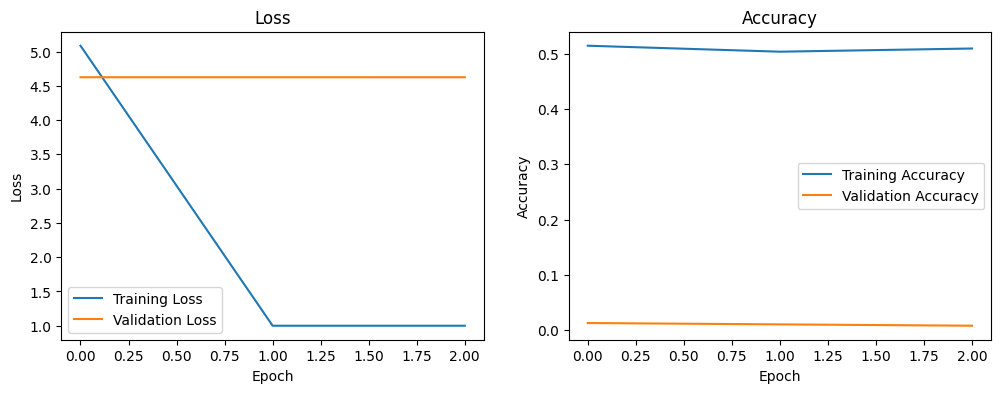

In [8]:
# After training, you can plot the training and validation losses and accuracies
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.legend()
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(valid_accuracies, label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.show()

In [11]:

# Create an instance of the CNNModel
model = CNNModel()

# Load the trained model's state dictionary
model.load_state_dict(torch.load('triplet_loss_model.pth'))
model.to(device)

# Switch the model to evaluation mode
model.eval()


CNNModel(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=401408, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=102, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (relu): ReLU()
)

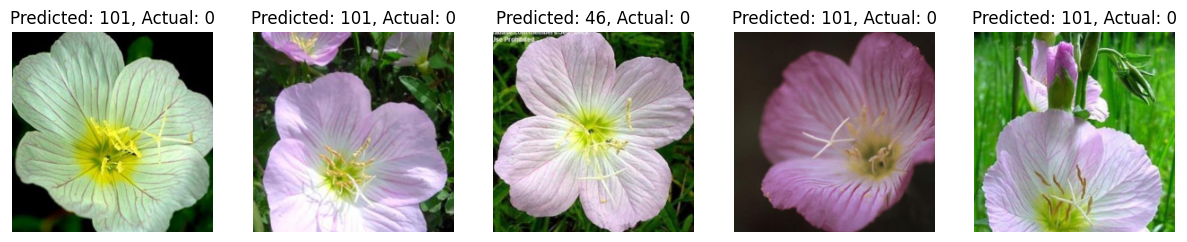

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Set the model to evaluation mode
model.eval()

# Function to display an image
def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    # PyTorch tensors assume the color channel is the first dimension
    image = image.cpu().numpy().transpose((1, 2, 0))  # Move to CPU and convert to numpy
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    image = np.clip(image, 0, 1)
    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')
    if title:
        ax.set_title(title)
    return ax

# Function to make predictions and display images
def visualize_predictions(model, dataloader, num_images=5):
    images, labels = next(iter(dataloader))
    images, labels = images.to(device), labels.to(device)
    output = model(images)
    
    _, preds = torch.max(output, 1)

    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    for i in range(num_images):
        imshow(images[i], ax=axes[i], title=f'Predicted: {preds[i].cpu().item()}, Actual: {labels[i].cpu().item()}')  # Move predictions to CPU

# Visualize model predictions on a few validation images
visualize_predictions(model, validloader, num_images=5)
